In [1]:
import numpy as np
import os
import pandas as pd
import collections
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,GRU,Input,Bidirectional,Activation,RNN,LSTM,SimpleRNN,TimeDistributed,Masking
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [2]:
#loading function
def load_data(path):
  data_file=os.path.join(path)
  with open(data_file,"r") as f:
    lang_data=f.read()
  return lang_data.split('\n')

In [3]:
#load english sentences
english_sentences=load_data('/kaggle/input/machine-translation/small_vocab_en.txt')
#load french sentences
french_sentences=load_data('/kaggle/input/machine-translation/small_vocab_fr.txt')

In [4]:
for sample in range(2):
  print(f'Small_vocab_en line {sample + 1} {english_sentences[sample]}')
  print(f'Small_vocab_fr line {sample + 1} {french_sentences[sample]}')

Small_vocab_en line 1 new jersey is sometimes quiet during autumn , and it is snowy in april .
Small_vocab_fr line 1 new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
Small_vocab_en line 2 the united states is usually chilly during july , and it is usually freezing in november .
Small_vocab_fr line 2 les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


In [5]:
english_word_counter=collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_word_counter=collections.Counter([word for sentence in french_sentences for word in sentence.split()])
print(f'There are {len([word for sentence in english_sentences for word in sentence.split()])} english words')
print(f'There are {len(english_word_counter)} unique english words')
print(f'There are {len([word for sentence in french_sentences for word in sentence.split()])} french words')
print(f'There are {len(french_word_counter)} unique french words')

There are 1823250 english words
There are 227 unique english words
There are 1961295 french words
There are 355 unique french words


In [6]:
#tokenize the sentences
def tokenize(x):
  x_tk=Tokenizer(char_level=False)
  x_tk.fit_on_texts(x)
  return x_tk.texts_to_sequences(x),x_tk
#test the tokenizer
tokenized_x,tokenizer_x=tokenize([english_sentences[0]])
print(tokenizer_x.word_index)

{'is': 1, 'new': 2, 'jersey': 3, 'sometimes': 4, 'quiet': 5, 'during': 6, 'autumn': 7, 'and': 8, 'it': 9, 'snowy': 10, 'in': 11, 'april': 12}


In [7]:
def pad(x, length=None):
  if length is None:
    length=max([len(sentence) for sentence in x])
  return pad_sequences(x, maxlen=length,padding='post')


In [8]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


In [10]:
def logits_to_text(logits,tokenizer):
  index_to_words={id:word for word,id in tokenizer.word_index.items()}
  index_to_words[0]='<PAD>'
  return  ' '.join([index_to_words[prediction] for prediction in np.argmax(logits,1)])

In [11]:
#Rnn
def Rnn_model(input_shape,output_sequence_length,english_vocab_size,french_vocab_size):
  input_seq=Input(input_shape[1:])
  rnn1=SimpleRNN(120,return_sequences=True)(input_seq)
  rnn2=SimpleRNN(120,return_sequences=True)(rnn1)
  logits=TimeDistributed(Dense(french_vocab_size +1))(rnn2)
  output = Activation('softmax')(logits)
  model=Model(input_seq,output)
  model.compile(
      loss=sparse_categorical_crossentropy,
      optimizer=Adam(learning_rate=0.001),
      metrics=['accuracy']

  )
  return model

tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape[1:])


(21, 1)


In [12]:
rnn_model = Rnn_model(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

rnn_model.summary()

history=rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=50, validation_split=0.2)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 21, 120)        │        14,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 21, 120)        │        28,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 21, 345)        │        41,745 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 21, 345)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,305 (333.22 KB)

 Trainable params: 85,305 (333.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1729108383.972895     100 service.cc:145] XLA service 0x7b429c005830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729108383.972942     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  30/6893 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.2977 - loss: 4.5409  

I0000 00:00:1729108388.141243     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6891/6893 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6171 - loss: 1.4800

W0000 00:00:1729108423.330527     101 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1729108428.104996     102 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


6893/6893 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.6171 - loss: 1.4799 - val_accuracy: 0.7122 - val_loss: 0.9298
Epoch 2/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.7163 - loss: 0.9032 - val_accuracy: 0.7274 - val_loss: 0.8327
Epoch 3/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.7344 - loss: 0.8164 - val_accuracy: 0.7526 - val_loss: 0.7513
Epoch 4/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.7559 - loss: 0.7444 - val_accuracy: 0.7589 - val_loss: 0.7192
Epoch 5/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.7676 - loss: 0.7061 - val_accuracy: 0.7779 - val_loss: 0.6827
Epoch 6/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7758 - loss: 0.6803 - val_accuracy: 0.7656 - val_loss: 0.6816
Epoch 7/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7863 - loss: 0.6468 - val_accuracy: 0.8037 - val_loss: 0.5994
Epoch 8/50
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.7904 - loss: 0.6354 - val

In [27]:
for i in range(10):
    prediction = rnn_model.predict(tmp_x[i:i+1])
    print(f'English sentence: {english_sentences[i]}')
    print(f'French translation:{logits_to_text(prediction[0], french_tokenizer)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
English sentence: new jersey is sometimes quiet during autumn , and it is snowy in april .
French translation:new jersey est parfois calme en l' de l' automne il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
English sentence: the united states is usually chilly during july , and it is usually freezing in november .
French translation:les états unis est généralement froid en juillet et il est généralement en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
English sentence: california is usually quiet during march , and it is usually hot in june .
French translation:californie est généralement habituellement en mars et il est généralement chaud en juin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
English sentence: the united states is sometimes mild during june , and it is cold in september .
French translation:les états unis e

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

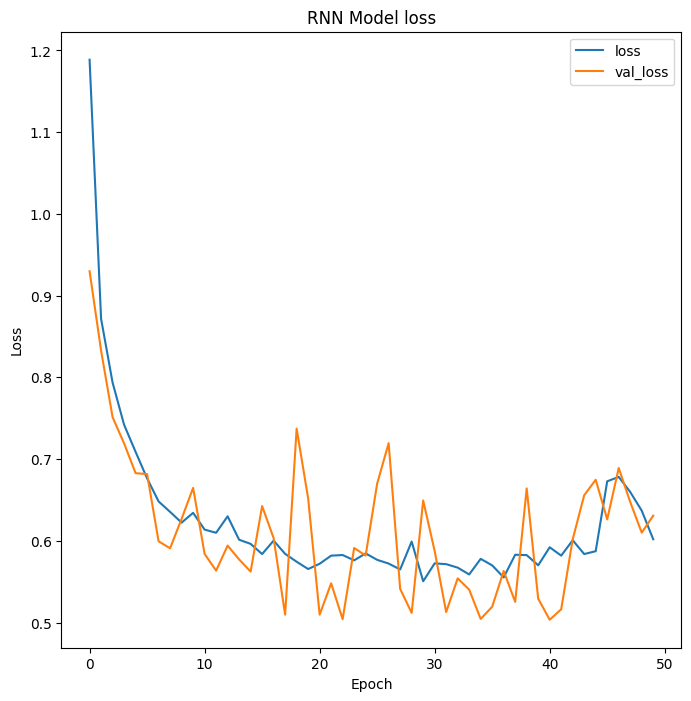

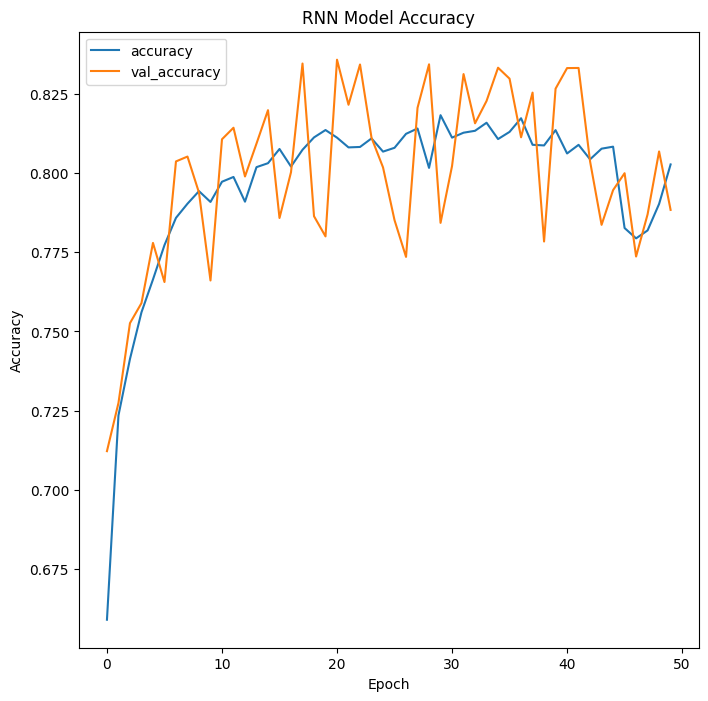

In [14]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train loss','val_loss':'validation loss'})
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train loss','val_accuracy':'validation loss'})
df_loss.plot(title='RNN Model loss',figsize=(8,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='RNN Model Accuracy',figsize=(8,8)).set(xlabel='Epoch',ylabel='Accuracy')


In [15]:
#LSTM
def Lstm_model(input_shape,output_sequence_length,english_vocab_size,french_vocab_size):
  input_seq=Input(input_shape[1:])
  lstm1=LSTM(128,return_sequences=True)(input_seq)
  lstm2=LSTM(128,return_sequences=True)(lstm1)
  logits=TimeDistributed(Dense(french_vocab_size +1))(lstm2)
  output = Activation('softmax')(logits)
  model=Model(input_seq,output)
  model.compile(
      loss=sparse_categorical_crossentropy,
      optimizer=Adam(learning_rate=0.001),
      metrics=['accuracy']

  )
  return model

tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape[1:])


(21, 1)


In [16]:
lstm_model = Lstm_model(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

lstm_model.summary()

history1=lstm_model.fit(tmp_x, preproc_french_sentences, batch_size=16, epochs=20, validation_split=0.2)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 21, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 21, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 21, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 21, 345)        │        44,505 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 21, 345)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,649 (947.85 KB)

 Trainable params: 242,649 (947.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 51s 7ms/step - accuracy: 0.6037 - loss: 1.5751 - val_accuracy: 0.6730 - val_loss: 1.0341
Epoch 2/20
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.7291 - loss: 0.8572 - val_accuracy: 0.7544 - val_loss: 0.7430
Epoch 3/20
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.7620 - loss: 0.7242 - val_accuracy: 0.7661 - val_loss: 0.6815
Epoch 4/20
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.7855 - loss: 0.6457 - val_accuracy: 0.7980 - val_loss: 0.6001
Epoch 5/20
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.8026 - loss: 0.5882 - val_accuracy: 0.8021 - val_loss: 0.5735
Epoch 6/20
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - accuracy: 0.8134 - loss: 0.5549 - val_accuracy: 0.7822 - val_loss: 0.6400
Epoch 7/20
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.8248 - loss: 0.5160 - val_accuracy: 0.8354 - val_loss: 0.4878
Epoch 8/20
6893/6893 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.8319 - loss: 0

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

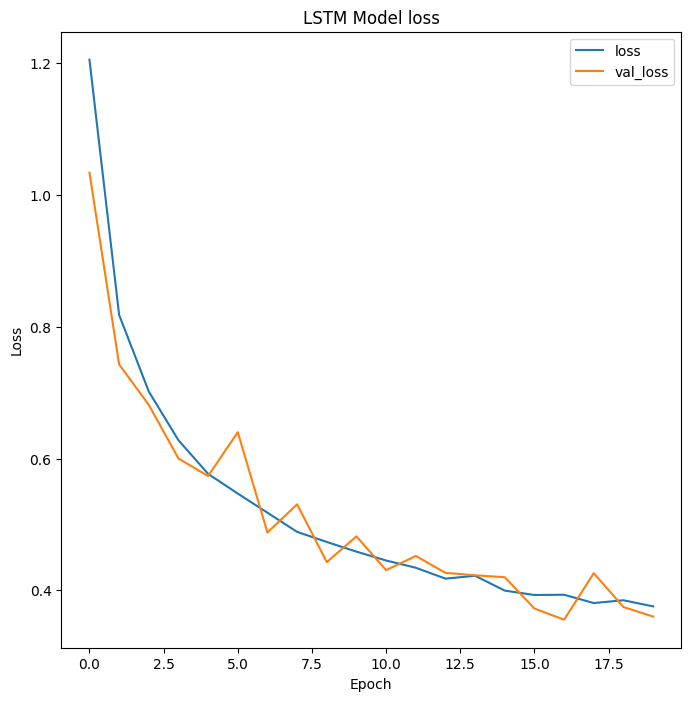

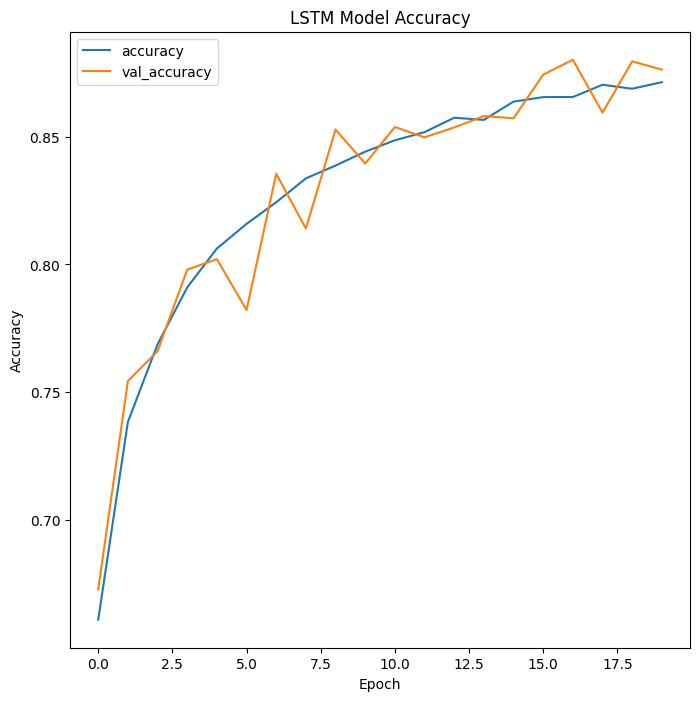

In [26]:
df_loss_acc = pd.DataFrame(history1.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train loss','val_loss':'validation loss'})
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train loss','val_accuracy':'validation loss'})
df_loss.plot(title='LSTM Model loss',figsize=(8,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='LSTM Model Accuracy',figsize=(8,8)).set(xlabel='Epoch',ylabel='Accuracy')


In [19]:
# prediction = lstm_model.predict(tmp_x[:1])
# print(logits_to_text(prediction[0], french_tokenizer))
for i in range(10):
    prediction = lstm_model.predict(tmp_x[i:i+1])
    print(f'English sentence: {english_sentences[i]}')
    print(f'French translation:{logits_to_text(prediction[0], french_tokenizer)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
English sentence: new jersey is sometimes quiet during autumn , and it is snowy in april .
French translation:new jersey est parfois calme en l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
English sentence: the united states is usually chilly during july , and it is usually freezing in november .
French translation:les états unis est généralement froid en juillet et il est généralement en l' <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
English sentence: california is usually quiet during march , and it is usually hot in june .
French translation:californie est généralement calme en mars et il est généralement chaud en juin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
English sentence: the united states is sometimes mild during june , and it is cold in september .
French translation:les états unis est par

In [49]:
#GRU
def Gru_model(input_shape,output_sequence_length,english_vocab_size,french_vocab_size):
  input_seq=Input(input_shape[1:])
  gru1=GRU(120,return_sequences=True)(input_seq)
  logits=TimeDistributed(Dense(french_vocab_size +1))(gru1)
  output = Activation('softmax')(logits)
  model=Model(input_seq,output)
  model.compile(
      loss=sparse_categorical_crossentropy,
      optimizer=Adam(learning_rate=0.01),
      metrics=['accuracy']

  )
  return model

tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape[1:])


(21, 1)


In [50]:
gru_model = Gru_model(tmp_x.shape,max_french_sequence_length,english_vocab_size,french_vocab_size)

gru_model.summary()

history2=lstm_model.fit(tmp_x, preproc_french_sentences, batch_size=20, epochs=10, validation_split=0.2)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 21, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 21, 120)        │        44,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 21, 345)        │        41,745 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 21, 345)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,025 (336.04 KB)

 Trainable params: 86,025 (336.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5515/5515 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - accuracy: 0.8990 - loss: 0.2964 - val_accuracy: 0.9062 - val_loss: 0.2754
Epoch 2/10
5515/5515 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.9020 - loss: 0.2825 - val_accuracy: 0.9058 - val_loss: 0.2746
Epoch 3/10
5515/5515 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.9012 - loss: 0.2892 - val_accuracy: 0.8945 - val_loss: 0.3315
Epoch 4/10
5515/5515 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.8991 - loss: 0.2929 - val_accuracy: 0.9077 - val_loss: 0.2660
Epoch 5/10
5515/5515 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.9038 - loss: 0.2785 - val_accuracy: 0.9110 - val_loss: 0.2623
Epoch 6/10
5515/5515 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.9062 - loss: 0.2689 - val_accuracy: 0.8984 - val_loss: 0.3007
Epoch 7/10
5515/5515 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - accuracy: 0.9044 - loss: 0.2737 - val_accuracy: 0.9125 - val_loss: 0.2531
Epoch 8/10
5515/5515 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.9048 - loss: 0

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

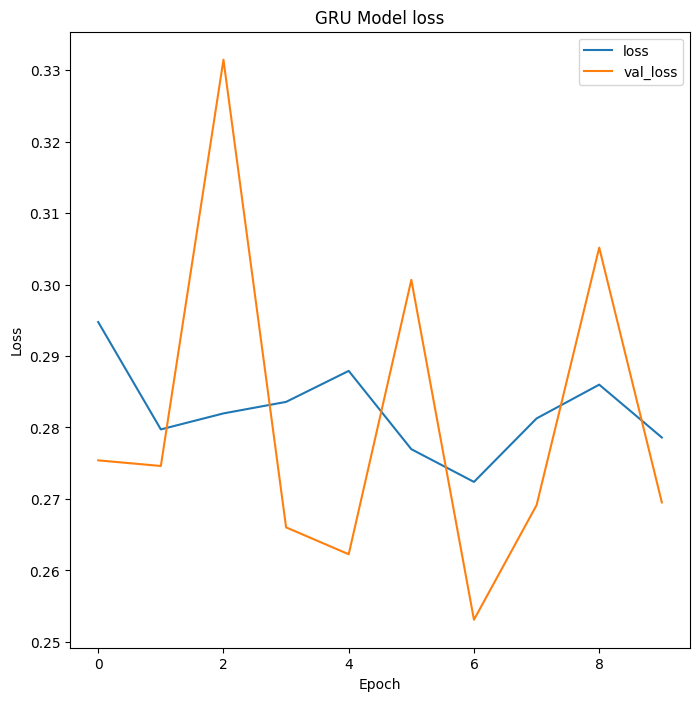

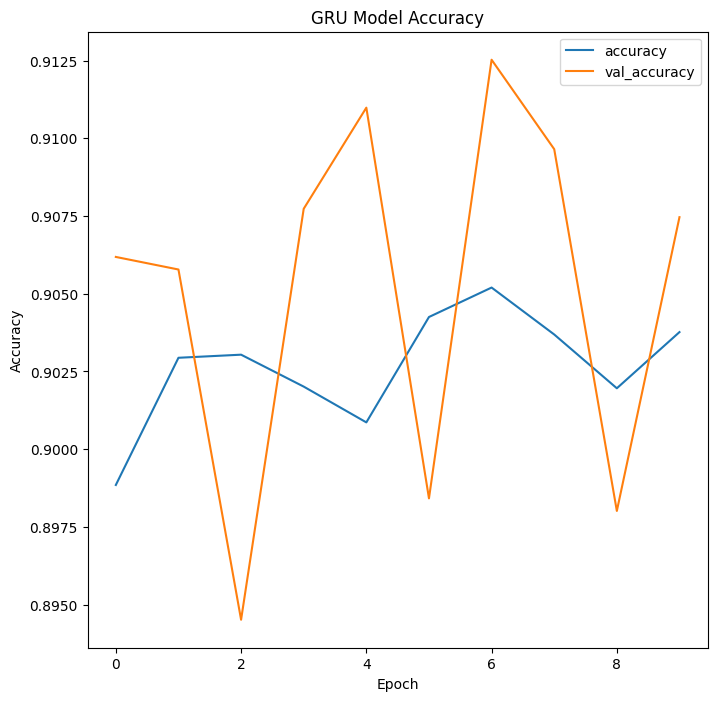

In [51]:
df_loss_acc = pd.DataFrame(history2.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train loss','val_loss':'validation loss'})
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train loss','val_accuracy':'validation loss'})
df_loss.plot(title='GRU Model loss',figsize=(8,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='GRU Model Accuracy',figsize=(8,8)).set(xlabel='Epoch',ylabel='Accuracy')


In [52]:
for i in range(10):
    prediction = gru_model.predict(tmp_x[i:i+1])
    print(f'English sentence: {english_sentences[i]}')
    print(f'French translation:{logits_to_text(prediction[0], french_tokenizer)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
English sentence: new jersey is sometimes quiet during autumn , and it is snowy in april .
French translation:limes limes gros gros limes gros lion gros gros gros lion lion lion lion gros gros terrain terrain terrain terrain terrain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
English sentence: the united states is usually chilly during july , and it is usually freezing in november .
French translation:gros limes limes gros gros limes gros lion gros gros gros gros limes gros lion lion gros gros terrain terrain terrain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
English sentence: california is usually quiet during march , and it is usually hot in june .
French translation:limes gros gros limes gros lion gros gros gros gros limes gros lion lion gros gros gros terrain terrain terrain terrain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
English sentence: the united states is sometimes mild during june , and it is cold in september .
French translation:gros limes limes gr

**Question 2**

In [28]:
from tensorflow.keras import layers,losses
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [29]:
train_data_path='/kaggle/input/autoencoder-dataset/train/train'
test_data_path='/kaggle/input/autoencoder-dataset/test/test'
train_clean_path='/kaggle/input/autoencoder-dataset/train_cleaned/train_cleaned'

In [30]:
train_images=[]
test_images=[]
train_cleaned_images=[]
for filename in os.listdir(train_data_path):
    image_path=os.path.join(train_data_path,filename)
    img=cv2.imread(image_path)
    if img is not None:
        img=cv2.resize(img,(240,240))
        train_images.append(img)
train_images=np.array(train_images)
for test_file in os.listdir(test_data_path):
    image_path=os.path.join(test_data_path,test_file)
    img=cv2.imread(image_path)
    if img is not None:
        img=cv2.resize(img,(240,240))
        test_images.append(img)
test_images=np.array(test_images)
for train_cleaned_file in os.listdir(train_clean_path):
    image_path=os.path.join(train_clean_path,train_cleaned_file)
    img=cv2.imread(image_path)
    if img is not None:
        img=cv2.resize(img,(240,240))
        train_cleaned_images.append(img)
train_cleaned_images=np.array(train_cleaned_images)
    

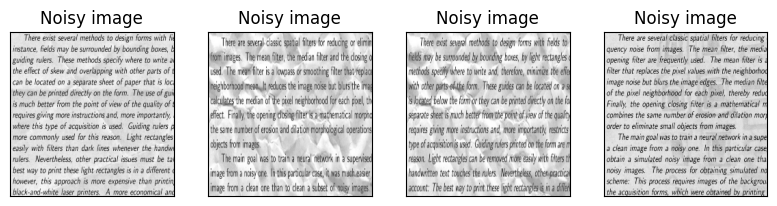

In [31]:
#Noise  images
plt.figure(figsize=(20,20))
for i in range(4):
  plt.subplot(8, 8, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_images[i])
  plt.title('Noisy image')
plt.show()

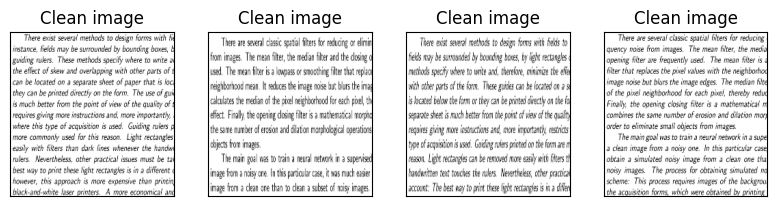

In [32]:
#cleaned images
plt.figure(figsize=(20,20))
for i in range(4):
  plt.subplot(8, 8, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_cleaned_images[i])
  plt.title('Clean image')
plt.show()

In [33]:
print('Train data shape',train_images.shape)
print('Test data shape',test_images.shape)
print('Clean images shape',train_cleaned_images.shape)

Train data shape (144, 240, 240, 3)
Test data shape (72, 240, 240, 3)
Clean images shape (144, 240, 240, 3)


In [34]:
#normalize the images
x_train=train_images.astype('float32')/255.0
y_train=train_cleaned_images.astype('float32')/255.0
x_test=test_images.astype('float32')/255.0
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(144, 240, 240, 3)
(144, 240, 240, 3)
(72, 240, 240, 3)


In [35]:
X_train, X_val, y_train ,y_val=train_test_split(x_train,y_train,test_size=0.3)
print('X_train',X_train.shape)
print('X_val', X_val.shape)

X_train (100, 240, 240, 3)
X_val (44, 240, 240, 3)


In [36]:
#Autoencoder model
def denoising_model(input_shape):
    #encoder
    input_img=Input(shape=input_shape)
    Z1=layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(input_img)
    A1=layers.ReLU()(Z1)
    P1=layers.MaxPool2D((2,2))(A1)
    #decoder
    Z3=layers.Conv2D(filters=128,kernel_size=(3,3),padding='same')(P1)
    A3=layers.ReLU()(Z3)
    U1=layers.UpSampling2D()(A3)
    A4=layers.ReLU()(U1)
    outputs=layers.Conv2D(filters=1,activation='sigmoid',kernel_size=(3,3),padding='same')(A4)
    model=Model(inputs=input_img,outputs=outputs)
    return model

In [37]:
autoencoder=denoising_model((240,240,3))
autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['RootMeanSquaredError'])

In [38]:
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 240, 240, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 240, 240, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 120, 120, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 120, 120, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 240, 240, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 240, 240, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 240, 240, 1)    │         1,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,321 (595.00 KB)

 Trainable params: 152,321 (595.00 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history3=autoencoder.fit(X_train,y_train,
                         epochs=200,
                         validation_data=(X_val,y_val)
                        )

Epoch 1/200
1/4 ━━━━━━━━━━━━━━━━━━━━ 35s 12s/step - RootMeanSquaredError: 0.4592 - loss: 0.2108

I0000 00:00:1729112581.715894     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - RootMeanSquaredError: 0.3927 - loss: 0.1560

I0000 00:00:1729112584.283289     100 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - RootMeanSquaredError: 0.3850 - loss: 0.1499 - val_RootMeanSquaredError: 0.2463 - val_loss: 0.0606
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - RootMeanSquaredError: 0.2471 - loss: 0.0611 - val_RootMeanSquaredError: 0.2590 - val_loss: 0.0671
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - RootMeanSquaredError: 0.2575 - loss: 0.0663 - val_RootMeanSquaredError: 0.2605 - val_loss: 0.0679
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - RootMeanSquaredError: 0.2592 - loss: 0.0672 - val_RootMeanSquaredError: 0.2596 - val_loss: 0.0674
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - RootMeanSquaredError: 0.2568 - loss: 0.0659 - val_RootMeanSquaredError: 0.2545 - val_loss: 0.0648
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - RootMeanSquaredError: 0.2506 - loss: 0.0628 - val_RootMeanSquaredError: 0.2353 - val_loss: 0.0554
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - RootMeanSquaredError: 0.2352 - loss: 0.0553 - val_RootM

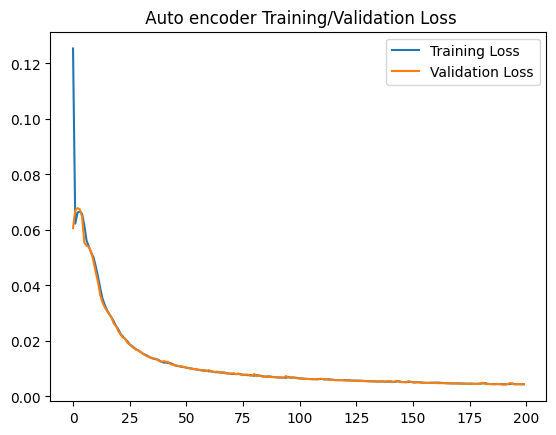

In [40]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title(' Auto encoder Training/Validation Loss')
plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [41]:
predictions = autoencoder.predict(x_test)
print('x_test shape',x_test.shape)
print('prediction shape',predictions.shape)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 658ms/step
x_test shape (72, 240, 240, 3)
prediction shape (72, 240, 240, 1)


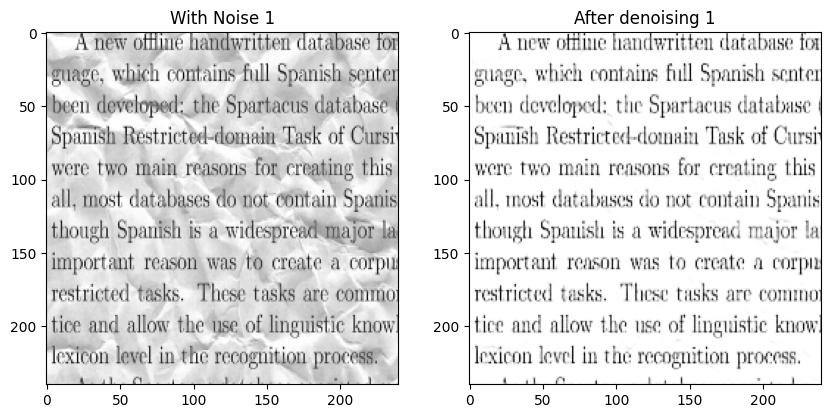

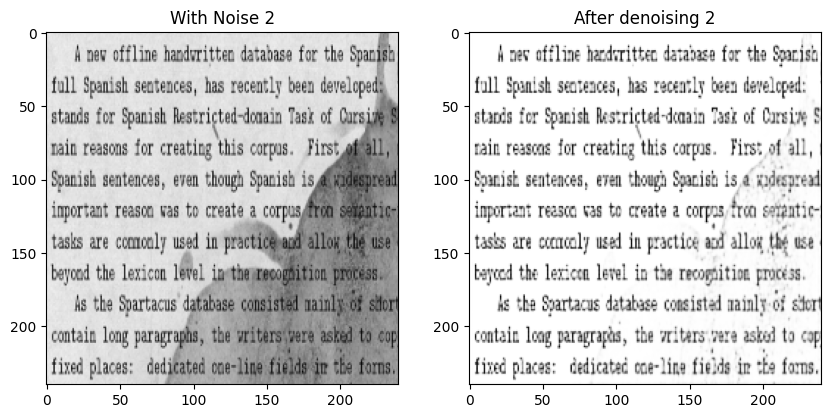

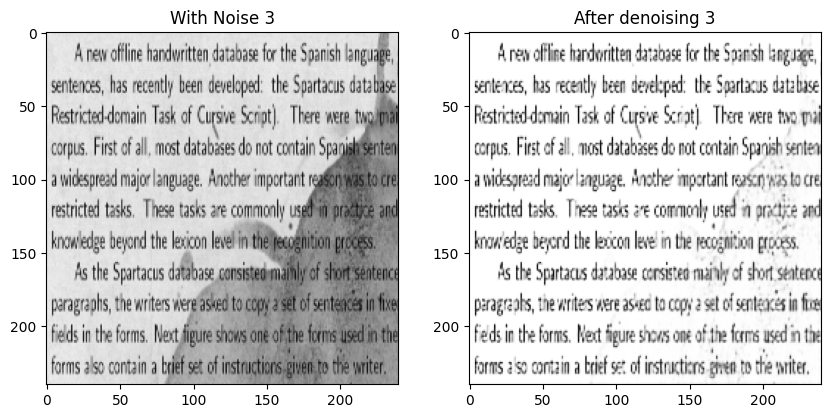

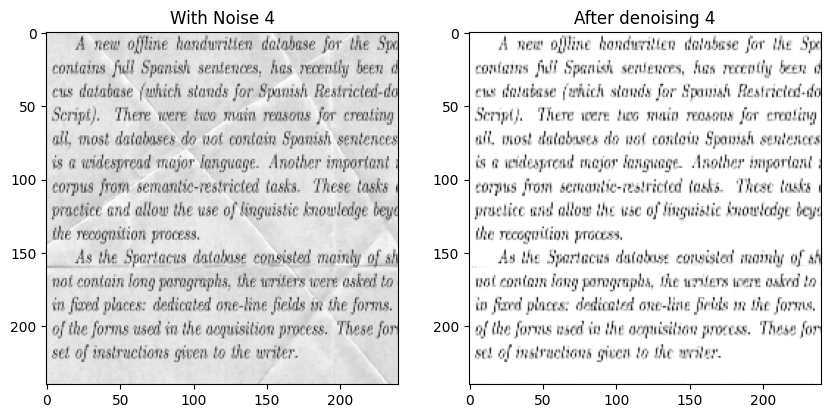

In [42]:
for i in range(4):
  f, axs = plt.subplots(1,2,figsize=(10,5))
  axs[0].imshow(x_test[i],cmap='gray')
  axs[0].title.set_text('With Noise '+str(i+1))
  axs[1].imshow(predictions[i],cmap='gray')
  axs[1].title.set_text("After denoising "+str(i+1))

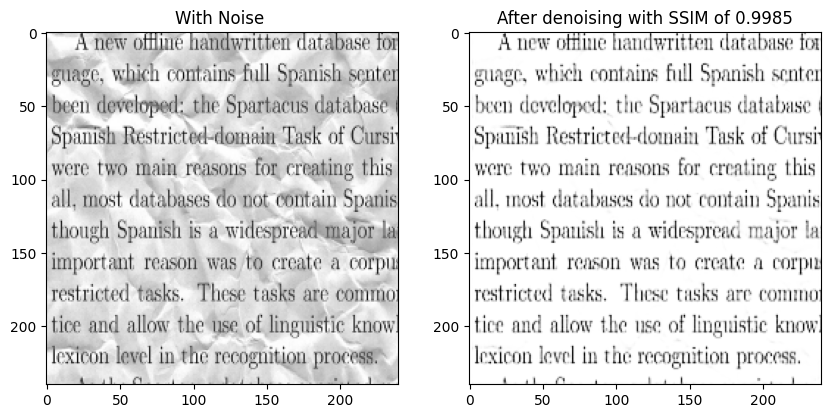

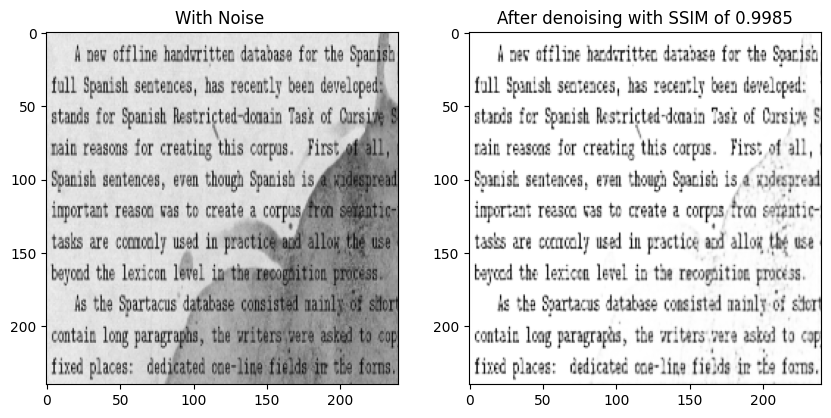

In [43]:
#SSIM
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
def gray_scale(image):
    if image.shape[-1]==3:
        return np.mean(image,axis=-1)
    return image
for i in range(4):
    img1=gray_scale(x_test[i])
    img2 = gray_scale(predictions[i])
    img2 = np.squeeze(img2)
    if img1.shape!=img2.shape:
        img2 = resize(img2, img1.shape, anti_aliasing=True)
    img1 = img1 / 255.0
    img2 = img2 / 255.0
    ssim_value, _=ssim(img1,img2,full=True,data_range=1.0)
for i in range(2):
  f, axs = plt.subplots(1,2,figsize=(10,5))
  axs[0].imshow(x_test[i],cmap='gray')
  axs[0].title.set_text('With Noise ')
  axs[1].imshow(predictions[i],cmap='gray')
  axs[1].title.set_text(f"After denoising with SSIM of {ssim_value:.4f}")
    

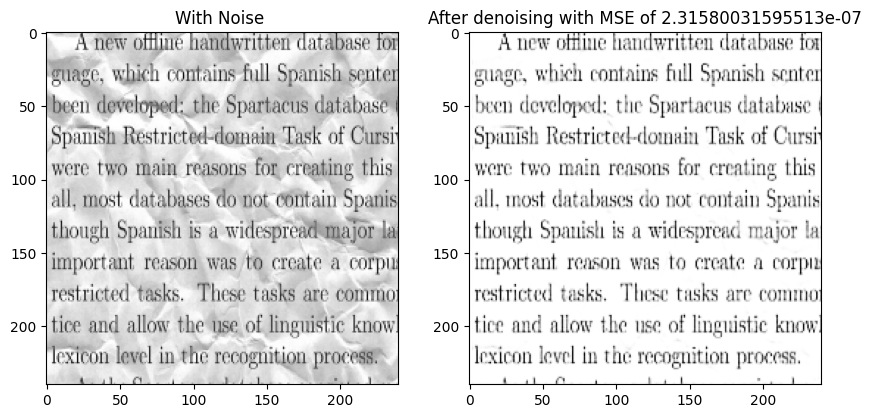

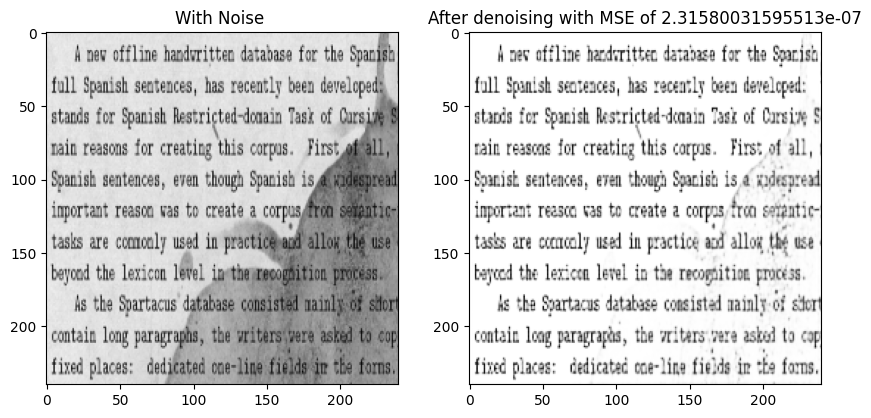

In [44]:
#MSE
for i in range(2):
  mse_value = mean_squared_error(img1.flatten(), img2.flatten())
  f, axs = plt.subplots(1,2,figsize=(10,5))
  axs[0].imshow(x_test[i],cmap='gray')
  axs[0].title.set_text('With Noise ')
  axs[1].imshow(predictions[i],cmap='gray')
  axs[1].title.set_text(f"After denoising with MSE of {mse_value}")